Updated: 12/8/2020

Scraping Craigslist's rental section to get accurate representation of the prices and square footage of 1 bedrooms throughout different Chicago neighorhoods.

In [51]:

#import get to call a get request on the site
from requests import get

#get the 1st page of the chicago housing prices 
#get rid of posts without a pic using their filter
response = get('https://chicago.craigslist.org/search/chc/apa?hasPic=1&availabilityMode=0')

from bs4 import BeautifulSoup
html_soup = BeautifulSoup(response.text, 'html.parser')

#get the macro-container for the housing posts
posts = html_soup.find_all('li', class_= 'result-row')
print(type(posts)) #to double check that I got a ResultSet
print(len(posts)) #to double check I got 120 (elements/page)

<class 'bs4.element.ResultSet'>
120


In [52]:
#get first post
post_one = posts[0]

In [53]:
#price of 1st post
post_one_price = post_one.a.text
#remove comma from listing. Need to do later for all the posts
#post_one_price = post_one.a.text.replace(',', '')
post_one_price.strip()

'$1,400'

In [54]:
#get the time of the post in datetime format
post_one_time = post_one.find('time', class_= 'result-date')
post_one_datetime = post_one_time['datetime']

In [55]:
#title is a and that class, link is grabbing the href attribute of that variable
post_one_title = post_one.find('a', class_='result-title hdrlnk')
post_one_link = post_one_title['href']

#easy to grab the post title by taking the text element of the title variable
post_one_title_text = post_one_title.text

In [56]:
#execute multiple statements per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [57]:
#grabs the whole segment of housing details. We will need missing value handling in the loop as this kind of detail is not common in posts
#the text can be split, and we can use indexing to grab the elements we want. number of bedrooms is the first element.
#sqft is the third element
post_one_num_bedrooms = post_one.find('span', class_ = 'housing').text.split()[0]
post_one_num_bedrooms

post_one_sqft = post_one.find('span', class_ = 'housing')
post_one_sqft

post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3]
post_one_sqft
#post_one_sqft = post_one.find('span', class_ = 'housing').text.split()[2][:-3] #cleans the ft2 at the end

'2br'

<span class="housing">
                    2br -
                </span>

IndexError: list index out of range

In [58]:
#the neighborhood is grabbed by finding the span class 'result-hood' and pulling the text element from there

post_one_hood = posts[0].find('span', class_='result-hood').text

In [59]:
#build out the loop
from time import sleep
import re
##this will allow us to scrape without getting blocked by craigslist
from random import randint #avoid throttling by not sending too many requests one after the other
from warnings import warn
from time import time
from IPython.core.display import clear_output
import numpy as np

#find the total number of posts to find the limit of the pagination
results_num = html_soup.find('div', class_= 'search-legend')
results_total = int(results_num.find('span', class_='totalcount').text) #pulled the total count of posts as the upper bound of the pages array

#each page has 119 posts so each new page is defined as follows: s=120, s=240, s=360, and so on. So we need to step in size 120 in the np.arange function
pages = np.arange(0, results_total+1, 120)

iterations = 0

post_timing = []
post_hoods = []
post_title_texts = []
bedroom_counts = []
sqfts = []
post_links = []
post_prices = []

for page in pages:
    
    #get request
    response = get("https://chicago.craigslist.org/search/chc/apa?" 
                   + "s=" #the parameter for defining the page number 
                   + str(page) #the page number in the pages array from earlier
                   + "&hasPic=1"
                   + "&availabilityMode=0")

    sleep(randint(1,5))
     
    #throw warning for status codes that are not 200
    if response.status_code != 200:
        warn('Request: {}; Status code: {}'.format(requests, response.status_code))
        
    #define the html text
    page_html = BeautifulSoup(response.text, 'html.parser')
    
    #define the posts
    posts = html_soup.find_all('li', class_= 'result-row')
        
    #extract data item-wise
    for post in posts:

        if post.find('span', class_ = 'result-hood') is not None:

            #posting date
            #grab the datetime element 0 for date and 1 for time
            post_datetime = post.find('time', class_= 'result-date')['datetime']
            post_timing.append(post_datetime)

            #neighborhoods
            post_hood = post.find('span', class_= 'result-hood').text
            post_hoods.append(post_hood)

            #title text
            post_title = post.find('a', class_='result-title hdrlnk')
            post_title_text = post_title.text
            post_title_texts.append(post_title_text)

            #post link
            post_link = post_title['href']
            post_links.append(post_link)
            
            #removes the \n whitespace from each side, removes the currency symbol, the comma 
            #and turns it into an int
            post_price = int(post.a.text.strip().replace("$", "").replace(",",""))
            #post_price = int(post.a.text.strip().replace(',', '')
            post_prices.append(post_price)
                        
            if post.find('span', class_ = 'housing') is not None:
                
                #if the first element is accidentally square footage
                if 'ft2' in post.find('span', class_ = 'housing').text.split()[0]:
                    
                    #make bedroom nan
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                    
                    #make sqft the first element
                    sqft = int(post.find('span', class_ = 'housing').text.split()[0][:-3])
                    sqfts.append(sqft)
                    
                #if the length of the housing details element is more than 2
                elif len(post.find('span', class_ = 'housing').text.split()) > 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = int(post.find('span', class_ = 'housing').text.split()[2][:-3])
                    sqfts.append(sqft)
                    
                #if there is num bedrooms but no sqft
                elif len(post.find('span', class_ = 'housing').text.split()) == 2:
                    
                    #therefore element 0 will be bedroom count
                    bedroom_count = post.find('span', class_ = 'housing').text.replace("br", "").split()[0]
                    bedroom_counts.append(bedroom_count)
                    
                    #and sqft will be number 3, so set these here and append
                    sqft = np.nan
                    sqfts.append(sqft)                    
                
                else:
                    bedroom_count = np.nan
                    bedroom_counts.append(bedroom_count)
                
                    sqft = np.nan
                    sqfts.append(sqft)
                
            #if none of those conditions catch, make bedroom nan, this won't be needed    
            else:
                bedroom_count = np.nan
                bedroom_counts.append(bedroom_count)
                
                sqft = np.nan
                sqfts.append(sqft)
            #    bedroom_counts.append(bedroom_count)
                
            #    sqft = np.nan
            #    sqfts.append(sqft)
                
    iterations += 1
    print("Page " + str(iterations) + " scraped successfully!")

print("\n")

print("Scrape complete!")

Page 1 scraped successfully!
Page 2 scraped successfully!
Page 3 scraped successfully!
Page 4 scraped successfully!
Page 5 scraped successfully!
Page 6 scraped successfully!
Page 7 scraped successfully!
Page 8 scraped successfully!
Page 9 scraped successfully!
Page 10 scraped successfully!
Page 11 scraped successfully!
Page 12 scraped successfully!
Page 13 scraped successfully!
Page 14 scraped successfully!
Page 15 scraped successfully!
Page 16 scraped successfully!
Page 17 scraped successfully!
Page 18 scraped successfully!
Page 19 scraped successfully!
Page 20 scraped successfully!
Page 21 scraped successfully!
Page 22 scraped successfully!
Page 23 scraped successfully!
Page 24 scraped successfully!
Page 25 scraped successfully!
Page 26 scraped successfully!


Scrape complete!


In [60]:
import pandas as pd

ch_apts = pd.DataFrame({'Posted': post_timing,
                       'Neighborhood': post_hoods,
                       'Post_Title': post_title_texts,
                       'Num_Bedrooms': bedroom_counts,
                        'Sqft': sqfts,
                        'URL': post_links,
                       'Price': post_prices})
print(ch_apts.info())
ch_apts.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2990 entries, 0 to 2989
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Posted        2990 non-null   object 
 1   Neighborhood  2990 non-null   object 
 2   Post_Title    2990 non-null   object 
 3   Num_Bedrooms  2704 non-null   object 
 4   Sqft          1040 non-null   float64
 5   URL           2990 non-null   object 
 6   Price         2990 non-null   int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 163.6+ KB
None


,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-12 20:07,(PILSEN),AMAZING 2bed/2 bath w/d in unit,2,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1400
1,2020-12-12 19:56,(Logan Square),HUGE 2 br/1 bath + Den - Logan Square - FREE M...,2,1435.0,https://chicago.craigslist.org/chc/apa/d/chica...,1795
2,2020-12-12 19:28,(Logan Square),live work loft style apartment,3,950.0,https://chicago.craigslist.org/chc/apa/d/chica...,1600
3,2020-12-12 19:20,(Chicago),Furnished Wicker Park 1-Bedroom Coachouse!,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,2150
4,2020-12-12 19:07,"(Lincoln Park, Chicago)",Beautiful 1 bedroom 1 bath apartment for rent ...,1,775.0,https://chicago.craigslist.org/chc/apa/d/chica...,1795
5,2020-12-12 19:00,(Lincoln Park),2704 N. Mildred Ave. Unit 2F,2,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,2075
6,2020-12-12 18:57,(Old Town),1433 N. Wells St. Unit 3F,3,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,3095
7,2020-12-12 18:56,(Lakeview),3257 N. Sheffield Ave. Unit 302,1,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1695
8,2020-12-12 18:55,(Ranch Triangle),1817 N. Clybourn Ave. Unit 1,3,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,2545
9,2020-12-12 18:53,(West Loop),123 N. Jefferson St. Unit 4R,4,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,3995


In [48]:
#export dataframe to csv file


In [ ]:
########################DATA CLEANING


In [61]:
#Deleting duplicate postings bc people spam Craigslist with fake postings
# the duplicate postings are most likely spam
#Displays uniqe posts
ch_apts = ch_apts.drop_duplicates(subset='URL')
len(ch_apts.drop_duplicates(subset='URL'))

#converts the # of bedrooms to a float (since np.nan is a float too)
ch_apts['Num_Bedrooms'] = ch_apts['Num_Bedrooms'].apply(lambda x: float(x))

#convert datetime string into datetime object to work with it
from datetime import datetime
ch_apts['Posted'] = pd.to_datetime(ch_apts['Posted'])

#Checking neighborhoods that there are with ch_apts['neighborhood'].unique()
#Seeing that allowed me to know what I needed to deal with in terms of cleaning those

#remove the parenthesis from the left and right of the neighborhoods
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].map(lambda x: x.lstrip('(').rstrip(')'))

ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: re.sub(r'[()]+', '', x))

#titlecase them
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].str.title()

#just take the first name of the neighborhood list, splitting on the '/' delimiter
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: x.split('/')[0])

#fix one-offs that
########################
#####################

#UPDATE
###################
########################
#remove whitespaces
ch_apts['Neighborhood'] = ch_apts['Neighborhood'].apply(lambda x: x.strip())

115

In [62]:
### EXPLORATORY DATA ANALYSIS
#Checking first record
ch_apts.head(1)
ch_apts.to_csv(r'C:\\Users\\chris\\2020\Craigslist_New.csv')

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-12 20:07:00,Pilsen,AMAZING 2bed/2 bath w/d in unit,2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1400


In [14]:
#Checking unique neighborhood names
ch_apts.Neighborhood.unique()

#removing listings that have addresses as listings
ch_apts = ch_apts[(ch_apts.Neighborhood != '1624 W. Division Street Wicker Park')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '775 West Diversey Pkwy.')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '3257 W Eastwood')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '4354 N Ashland')]
ch_apts = ch_apts[(ch_apts.Neighborhood != 'All Pets')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '3750 N. Troy Street Apt. 1')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1550 S Hamlin  North Lawndale')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '8901 S Loomis - Brainerd Senior Center')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1436-40 W Thorndale')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '3257 W Eastwood')]
ch_apts = ch_apts[(ch_apts.Neighborhood != '1234 W Loyola')]






#(ch_apts.Neighborhood != 10)]

ch_apts.Neighborhood.unique()


array(['Lakeview', 'West Loop', 'River North', 'Chicago',
       'East Rogers Park', 'Logan Square', 'South Loop Mccormick Square',
       'Portage Park', '6948 S. Talman - Chicago Lawn', 'Mckinley Park',
       '75Th & Dan Ryan', 'Edgewater', 'West Lawn, Chicago',
       'Lincoln Park', 'Marshall Square', 'Roscoe Village',
       'Gold Coast - 1133 N. Dearborn', 'River North - 750 N. Rush',
       'Gold Coast - 20 E. Scott', 'Gold Coast - 1330 N. Dearborn',
       'River North - 100 W. Chestnut', 'Gold Coast - 1120 N. Lasalle',
       'West Loop Chicago', 'Old Town Triangle',
       'Mckinley Park, Chicago, Il', 'Marshall Square Chicago Il',
       'South Douglas Park West Pilsen', 'Brickyard',
       'Prime Brighton Park  60632', 'Pilsen', 'South Loop',
       'Chicago, Illinois', 'Andersonville', 'Gold Coast',
       'Lincoln Square', 'Wrigleyville', 'Auburn Gresham',
       'Chicago Lakeview Area', 'Rogers Park', 'Bucktown', 'East Village',
       'Edgewater - Andersonville', 'Wick

array(['Lakeview', 'West Loop', 'River North', 'Chicago',
       'East Rogers Park', 'Logan Square', 'South Loop Mccormick Square',
       'Portage Park', '6948 S. Talman - Chicago Lawn', 'Mckinley Park',
       '75Th & Dan Ryan', 'Edgewater', 'West Lawn, Chicago',
       'Lincoln Park', 'Marshall Square', 'Roscoe Village',
       'Gold Coast - 1133 N. Dearborn', 'River North - 750 N. Rush',
       'Gold Coast - 20 E. Scott', 'Gold Coast - 1330 N. Dearborn',
       'River North - 100 W. Chestnut', 'Gold Coast - 1120 N. Lasalle',
       'West Loop Chicago', 'Old Town Triangle',
       'Mckinley Park, Chicago, Il', 'Marshall Square Chicago Il',
       'South Douglas Park West Pilsen', 'Brickyard',
       'Prime Brighton Park  60632', 'Pilsen', 'South Loop',
       'Chicago, Illinois', 'Andersonville', 'Gold Coast',
       'Lincoln Square', 'Wrigleyville', 'Auburn Gresham',
       'Chicago Lakeview Area', 'Rogers Park', 'Bucktown', 'East Village',
       'Edgewater - Andersonville', 'Wick

In [15]:
#Correcting neighborhood names
for Post_Title in ch_apts:
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Andersonville'), 'Neighborhood'] = 'Andersonville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('andersonville'), 'Neighborhood'] = 'Andersonville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Archer Heights'), 'Neighborhood'] = 'Archer Heights'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('archer Heights'), 'Neighborhood'] = 'Archer Heights'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ashburn'), 'Neighborhood'] = 'Ashburn'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ashburn'), 'Neighborhood'] = 'Ashburn'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Austin'), 'Neighborhood'] = 'Austin'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('austin'), 'Neighborhood'] = 'Austin'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('avon'), 'Neighborhood'] = 'Avondale'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Avon'), 'Neighborhood'] = 'Avondale'  
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Albany'), 'Neighborhood'] = 'Albany Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('albany'), 'Neighborhood'] = 'Albany Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Beverly'), 'Neighborhood'] = 'Beverly'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('beverly'), 'Neighborhood'] = 'Beverly'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('buck'), 'Neighborhood'] = 'Bucktown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Buck'), 'Neighborhood'] = 'Bucktown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Boys'), 'Neighborhood'] = 'Boystown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('boys'), 'Neighborhood'] = 'Boystown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('China'), 'Neighborhood'] = 'Chinatown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('china'), 'Neighborhood'] = 'Chinatown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Depaul'), 'Neighborhood'] = 'Depaul'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('depaul'), 'Neighborhood'] = 'Depaul'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Edison'), 'Neighborhood'] = 'Edison Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('edison'), 'Neighborhood'] = 'Edison Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Edgewater'), 'Neighborhood'] = 'Edgewater'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('edgewater'), 'Neighborhood'] = 'Edgewater'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Englewood'), 'Neighborhood'] = 'Englewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('englewood'), 'Neighborhood'] = 'Englewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Galewood'), 'Neighborhood'] = 'Galewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('galewood'), 'Neighborhood'] = 'Galewood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Garfield Park'), 'Neighborhood'] = 'Garfield Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('garfield Park'), 'Neighborhood'] = 'Garfield Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Gold Coast'), 'Neighborhood'] = 'Gold Coast'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('gold'), 'Neighborhood'] = 'Gold Coast'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Gresham'), 'Neighborhood'] = 'Gresham'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('gresham'), 'Neighborhood'] = 'Gresham'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Humb'), 'Neighborhood'] = 'Humboldt Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('humb'), 'Neighborhood'] = 'Humboldt Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Hyde'), 'Neighborhood'] = 'Hyde Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('hyde'), 'Neighborhood'] = 'Hyde Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Jefferson'), 'Neighborhood'] = 'Jefferson Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('jefferson'), 'Neighborhood'] = 'Jefferson Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Kenwood'), 'Neighborhood'] = 'Kenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('kenwood'), 'Neighborhood'] = 'Kenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lakeview'), 'Neighborhood'] = 'Lakeview'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lakeview'), 'Neighborhood'] = 'Lakeview'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Little Village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Little village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('little village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lil village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lil village'), 'Neighborhood'] = 'Little Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lincoln Park'), 'Neighborhood'] = 'Lincoln Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lincoln park'), 'Neighborhood'] = 'Lincoln Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Lincoln Square'), 'Neighborhood'] = 'Lincoln Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('lincoln square'), 'Neighborhood'] = 'Lincoln Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Logan'), 'Neighborhood'] = 'Logan Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('logan'), 'Neighborhood'] = 'Logan Square'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Marquette Park'), 'Neighborhood'] = 'Marquette Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('marquette park'), 'Neighborhood'] = 'Marquette Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Midway'), 'Neighborhood'] = 'Midway'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('midway'), 'Neighborhood'] = 'Midway'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Mount Greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('mount greenwood'), 'Neighborhood'] = 'Mount Greenwood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Norwood'), 'Neighborhood'] = 'Norwood Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('norwood'), 'Neighborhood'] = 'Norwood Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Irving'), 'Neighborhood'] = 'Irving Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('irving'), 'Neighborhood'] = 'Irving Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Old Town'), 'Neighborhood'] = 'Old Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('old town'), 'Neighborhood'] = 'Old Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Pilsen'), 'Neighborhood'] = 'Pilsen'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('pilsen'), 'Neighborhood'] = 'Pilsen'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Portage'), 'Neighborhood'] = 'Portage Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('portage'), 'Neighborhood'] = 'Portage Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Pullman'), 'Neighborhood'] = 'Pullman'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('pullman'), 'Neighborhood'] = 'Pullman'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ravens'), 'Neighborhood'] = 'Ravenswood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ravens'), 'Neighborhood'] = 'Ravenswood'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('River North'), 'Neighborhood'] = 'River North'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('river north'), 'Neighborhood'] = 'River North'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('River West'), 'Neighborhood'] = 'River West'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('river west'), 'Neighborhood'] = 'River West'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Rogers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('rogers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('rodgers'), 'Neighborhood'] = 'Rogers Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Roscoe Village'), 'Neighborhood'] = 'Roscoe Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('roscoe village'), 'Neighborhood'] = 'Roscoe Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Sauganash'), 'Neighborhood'] = 'Sauganash'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('sauganash'), 'Neighborhood'] = 'Sauganash'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('South Loop'), 'Neighborhood'] = 'South Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('south loop'), 'Neighborhood'] = 'South Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('South Shore'), 'Neighborhood'] = 'South Shore'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('south shore'), 'Neighborhood'] = 'South Shore'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Streeter'), 'Neighborhood'] = 'Streeterville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('streeter'), 'Neighborhood'] = 'Streeterville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Uptown'), 'Neighborhood'] = 'Uptown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('uptown'), 'Neighborhood'] = 'Uptown'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('West Loop'), 'Neighborhood'] = 'West Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('west loop'), 'Neighborhood'] = 'West Loop'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('West Town'), 'Neighborhood'] = 'West Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('west town'), 'Neighborhood'] = 'West Town'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Wicker'), 'Neighborhood'] = 'Wicker Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wicker'), 'Neighborhood'] = 'Wicker Park'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wrigleyville'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('wrigley'), 'Neighborhood'] = 'Wrigleyville'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('Ukrainian Village'), 'Neighborhood'] = 'Ukrainian Village'
  ch_apts.loc[ch_apts['Post_Title'].str.contains('ukrainian village'), 'Neighborhood'] = 'Ukrainian Village'

ch_apts

,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,2020-12-12 18:47:00,Lakeview,3600 N. Hermitage Ave. Unit 2,3.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,2145
1,2020-12-12 18:44:00,West Loop,1501 W. Jackson St. Unit G,2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1845
2,2020-12-12 18:37:00,River North,2 BED 2 BATH RIVER NORTH,2.0,1300.0,https://chicago.craigslist.org/chc/apa/d/chica...,2995
3,2020-12-12 18:24:00,Chicago,2BD / 1BA Apartment,2.0,950.0,https://chicago.craigslist.org/chc/apa/d/chica...,1350
4,2020-12-12 18:10:00,Rogers Park,"Amazing duplex, best location 3bd 2bath in Rog...",3.0,1600.0,https://chicago.craigslist.org/chc/apa/d/chica...,1995
...,...,...,...,...,...,...,...
110,2020-12-12 06:17:00,Humboldt Park,Bright 1 FURNISHED Bdrm/1 Bath in Humboldt Park,1.0,725.0,https://chicago.craigslist.org/chc/apa/d/chica...,1350
111,2020-12-12 05:21:00,West Loop,2 Bedroom 2 Bath,2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,2635
112,2020-12-12 03:56:00,Chicago,3 Bedroom Ready To Move In,3.0,967.0,https://chicago.craigslist.org/chc/apa/d/chica...,850
113,2020-12-12 00:16:00,Uptown,3 bedroom apt Edgewater/uptown,3.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1800


In [16]:
ch_apts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 115 entries, 0 to 114
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Posted        115 non-null    datetime64[ns]
 1   Neighborhood  115 non-null    object        
 2   Post_Title    115 non-null    object        
 3   Num_Bedrooms  104 non-null    float64       
 4   Sqft          40 non-null     float64       
 5   URL           115 non-null    object        
 6   Price         115 non-null    int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 7.2+ KB


In [46]:
import pandas as pd, numpy as np

#get current directory
%pwd

#export dataframe to csv file
ch_apts.to_csv(r'C:\\Users\\chris\\2020\Craigslist-Data.csv')

'C:\\Users\\chris\\2020'

In [47]:
#use created file
chicago_apts = pd.read_csv("Craigslist-Data.csv")

chicago_apts.info()
chicago_apts.shape
chicago_apts.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    115 non-null    int64  
 1   Posted        115 non-null    object 
 2   Neighborhood  115 non-null    object 
 3   Post_Title    115 non-null    object 
 4   Num_Bedrooms  104 non-null    float64
 5   Sqft          40 non-null     float64
 6   URL           115 non-null    object 
 7   Price         115 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 7.3+ KB


(115, 8)

Index(['Unnamed: 0', 'Posted', 'Neighborhood', 'Post_Title', 'Num_Bedrooms',
       'Sqft', 'URL', 'Price'],
      dtype='object')

<Figure size 720x432 with 0 Axes>

(array([23., 27., 28., 12.,  5., 10.,  5.,  2.,  2.,  1.]),
 array([ 670. , 1052.5, 1435. , 1817.5, 2200. , 2582.5, 2965. , 3347.5,
        3730. , 4112.5, 4495. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'Price')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of Rent')

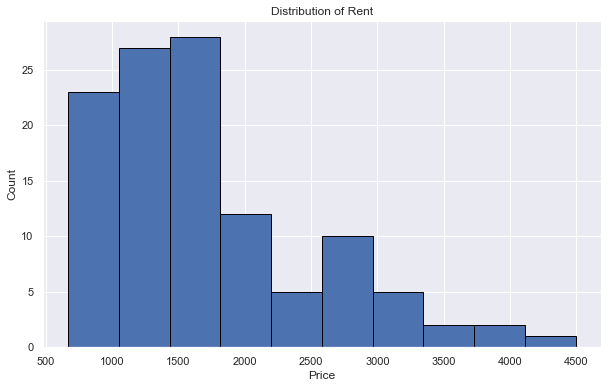

In [19]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
sns.set_style('darkgrid')
sns.set()
plt.hist(chicago_apts['Price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Rent");
plt.show()


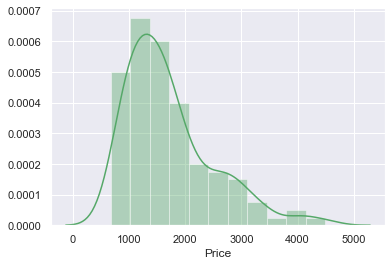

In [20]:
sns.set(color_codes=True)
sns.distplot(chicago_apts['Price'], color='g')
plt.show()

# Show the plot
plt.show()


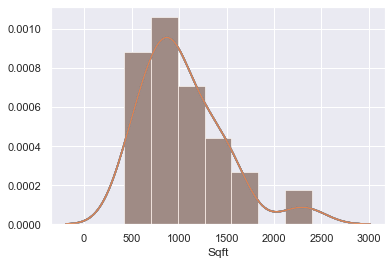

In [21]:
for p in sns.palettes.SEABORN_PALETTES:
    sns.set_palette(p)
    sns.distplot(chicago_apts['Sqft'])

[(350, 2100),
 Text(0.5, 0, '1 Bedroom Fair Market Rent'),
 Text(0.5, 1.0, 'US Rent')]

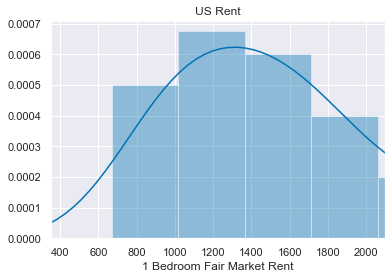

In [22]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the distribution of rents
sns.distplot(chicago_apts['Price'], ax=ax)

# Modify the properties of the plot
ax.set(xlabel="1 Bedroom Fair Market Rent",
       xlim=(350,2100),
       title="US Rent")

# Display the plot
plt.show()


[(250, 2250),
 Text(0.5, 0, 'Sq Footage of Chicago Apts'),
 Text(0.5, 1.0, 'US Rent')]

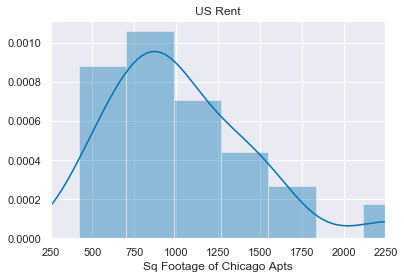

In [23]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the distribution of rents
sns.distplot(chicago_apts['Sqft'], ax=ax)

# Modify the properties of the plot
ax.set(xlabel="Sq Footage of Chicago Apts",
       xlim=(250,2250),
       title="US Rent")

# Display the plot
plt.show()

Sqft                            420.0   450.0   500.0   508.0   600.0   \
Neighborhood                                                             
6948 S. Talman - Chicago Lawn        0       0       1       0       0   
Auburn Gresham                       0       0       0       0       0   
Brickyard                            0       0       0       0       0   
Bucktown                             0       0       0       0       1   
Chicago                              0       0       0       0       0   
Gold Coast                           0       0       0       0       0   
Humboldt Park                        0       0       0       0       0   
Jefferson Park                       0       0       0       0       0   
Lincoln Park                         0       0       0       0       0   
Logan Square                         0       1       0       0       0   
Marshall Square                      0       0       0       1       0   
Marshall Square Chicago Il           0

(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5]),
 <a list of 13 Text yticklabel objects>)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5]),
 <a list of 27 Text xticklabel objects>)

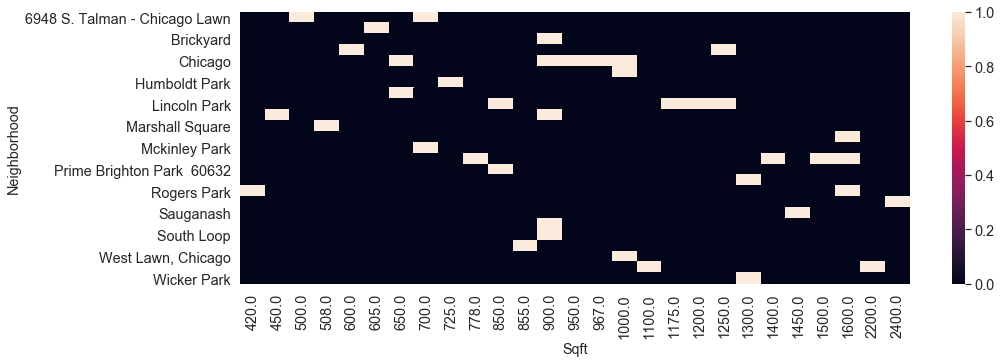

In [45]:
# Create a crosstab table of the data
pd_crosstab = pd.crosstab(chicago_apts["Neighborhood"], chicago_apts["Sqft"])
print(pd_crosstab)
# Plot a heatmap of the table
sns.heatmap(pd_crosstab)
# Rotate tick marks for visibility
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()


In [24]:
from statistics import *

[(400, 3000),
 Text(0.5, 0, 'Chicago Fair Market Rent'),
 Text(0.5, 1.0, 'Chicago Rent')]

TypeError: '>' not supported between instances of 'float' and 'function'

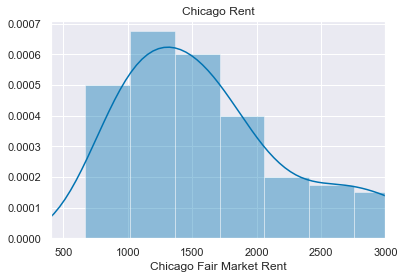

In [25]:
from statistics import *

# Create figure and axes / plot
fig, ax = plt.subplots()
sns.distplot(chicago_apts['Price'], ax=ax)

# Customize the labels and limits
ax.set(xlabel="Chicago Fair Market Rent", xlim=(400,3000), title="Chicago Rent")

# Add vertical lines for the median and mean
ax.axvline(x=median, color='m', label='Median', linestyle='--', linewidth=2)
ax.axvline(x=mean, color='b', label='Mean', linestyle='-', linewidth=2)

# Show the legend and plot the data
ax.legend()
plt.show()


NameError: name 'df' is not defined

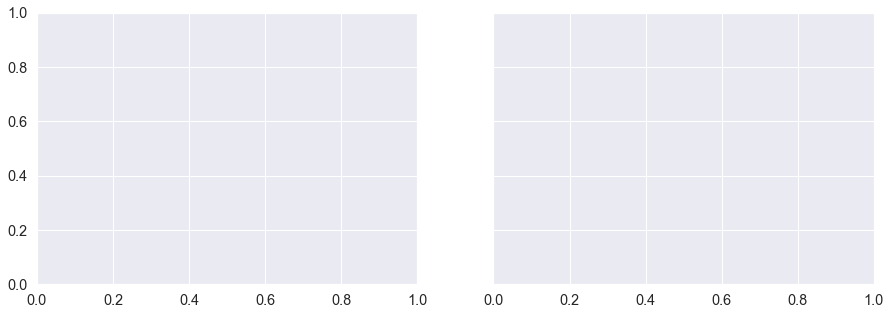

In [49]:
##NEED TO CREATE 1 Bedroom and 2 Bedroom datasets
# Create a plot with 1 row and 2 columns that share the y axis label
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharey=True)

# alter df to be dataset with 2 bedrooms
sns.distplot(df['fmr_1'], ax=ax0)
ax0.set(xlabel="1 Bedroom Fair Market Rent", xlim=(100,1500))

# alter df to be dataset with 2 bedrooms
sns.distplot(df['fmr_2'], ax=ax1)
ax1.set(xlabel="2 Bedroom Fair Market Rent", xlim=(100,1500))

# Display the plot
plt.show()


In [27]:
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))

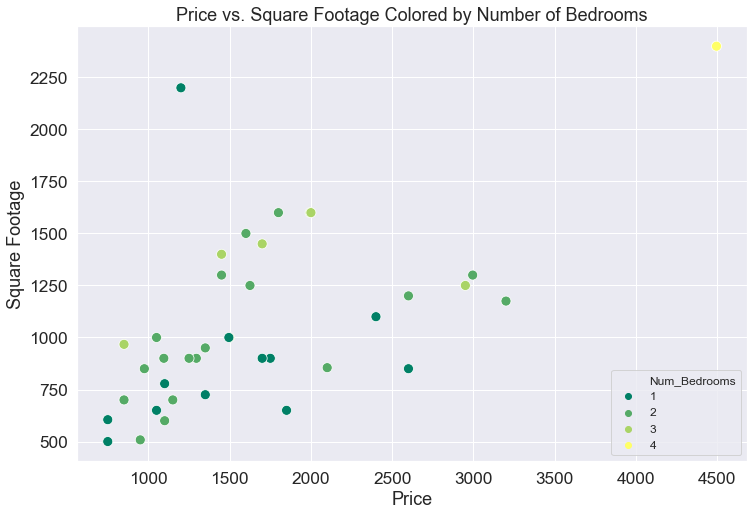

In [28]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Sqft', hue='Num_Bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=100, data=ch_apts.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

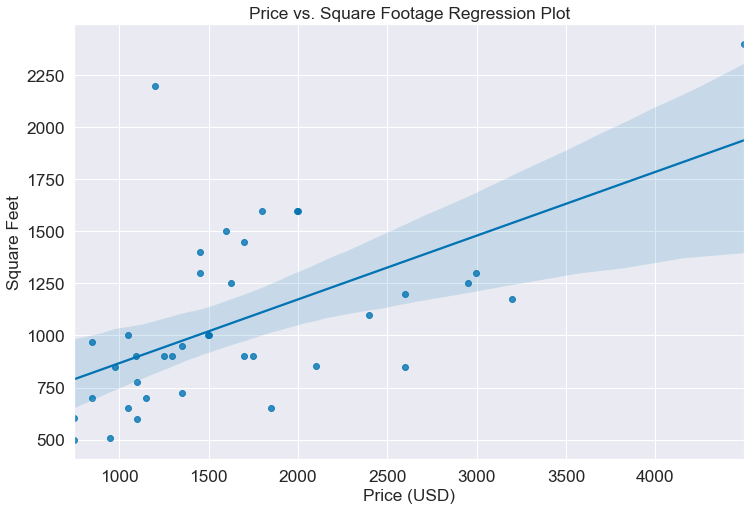

In [29]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=ch_apts.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [30]:
#correlations of # of bedrooms, sqft and price
ch_apts.corr()

,Num_Bedrooms,Sqft,Price
Num_Bedrooms,1.00000,0.517720,0.532440
Sqft,0.51772,1.000000,0.596988
Price,0.53244,0.596988,1.000000


In [31]:
#group by neighborhood
ch_apts.groupby('Neighborhood').mean()

,Num_Bedrooms,Sqft,Price
Neighborhood,,,
6948 S. Talman - Chicago Lawn,1.500000,600.00,800.000000
75Th & Dan Ryan,3.000000,NaN,850.000000
Andersonville,NaN,NaN,800.000000
Auburn Gresham,1.000000,605.00,750.000000
Brickyard,2.000000,900.00,1295.000000
Bucktown,2.000000,925.00,1362.500000
Buena Park,NaN,NaN,850.000000
Chicago,2.200000,893.40,1360.000000
Chicago Bridgeport,3.000000,NaN,1900.000000


In [32]:
#sort price to find cheapest
ch_apts.groupby('Neighborhood').mean()['Price'].sort_values()

Neighborhood
Midway Area                        675.000000
Auburn Gresham                     750.000000
6948 S. Talman - Chicago Lawn      800.000000
Andersonville                      800.000000
75Th & Dan Ryan                    850.000000
Buena Park                         850.000000
Marshall Square                    950.000000
Prime Brighton Park  60632         975.000000
Chicago Lakeview Area              998.000000
Edgewater                         1017.250000
West Lawn, Chicago                1050.000000
South Douglas Park West Pilsen    1095.000000
Lincoln Square                    1100.000000
Mckinley Park                     1125.000000
Gold Coast - 1330 N. Dearborn     1260.000000
Uptown                            1262.000000
Brickyard                         1295.000000
Loop                              1300.000000
Gold Coast - 1120 N. Lasalle      1329.000000
Humboldt Park                     1350.000000
Fulton                            1350.000000
Chicago              

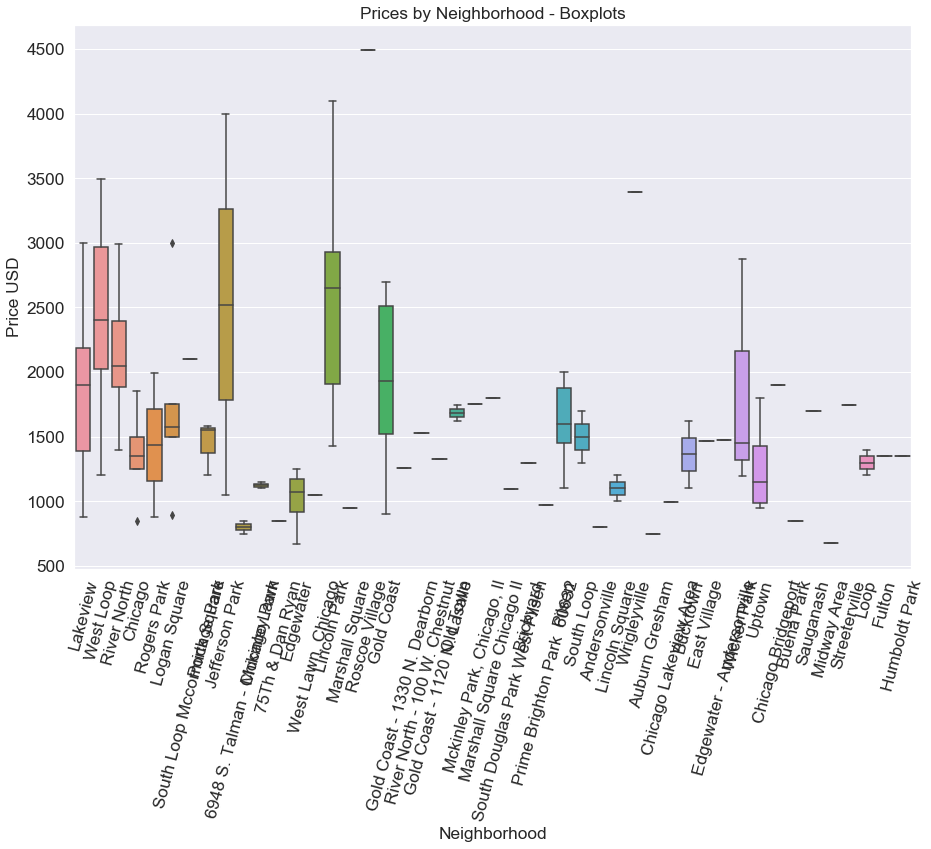

In [33]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='Neighborhood', y='Price', data=ch_apts)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood - Boxplots");

In [34]:
############################
############################
# 1 bedroom apts
###########################
###########################
###########################

# get 5 most popular neighborhoods 
chicago_apts['Neighborhood'].value_counts()[:5].index.tolist()

#break it down and do a sns barplot below with the Neighborhood hue so you can compare those different areas
#sns.stripplot(data=chicago_apts, y="Price",x="Num_Bedrooms", jitter=True)
#sns.barplot(data=chicago_apts, y= "Price", x="Num_Bedrooms",hue="Neighborhood")

['Lakeview', 'Lincoln Park', 'West Loop', 'Gold Coast', 'Chicago']

In [35]:
#Focusing on 1 bedroom apts
#use created file
chicago_apts = pd.read_csv("Craigslist-Data.csv")

chicago_apts.info()
chicago_apts.shape
chicago_apts.columns
chicago_apts.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    115 non-null    int64  
 1   Posted        115 non-null    object 
 2   Neighborhood  115 non-null    object 
 3   Post_Title    115 non-null    object 
 4   Num_Bedrooms  104 non-null    float64
 5   Sqft          40 non-null     float64
 6   URL           115 non-null    object 
 7   Price         115 non-null    int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 7.3+ KB


(115, 8)

Index(['Unnamed: 0', 'Posted', 'Neighborhood', 'Post_Title', 'Num_Bedrooms',
       'Sqft', 'URL', 'Price'],
      dtype='object')

,Unnamed: 0,Posted,Neighborhood,Post_Title,Num_Bedrooms,Sqft,URL,Price
0,0,2020-12-12 18:47:00,Lakeview,3600 N. Hermitage Ave. Unit 2,3.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,2145
1,1,2020-12-12 18:44:00,West Loop,1501 W. Jackson St. Unit G,2.0,NaN,https://chicago.craigslist.org/chc/apa/d/chica...,1845
2,2,2020-12-12 18:37:00,River North,2 BED 2 BATH RIVER NORTH,2.0,1300.0,https://chicago.craigslist.org/chc/apa/d/chica...,2995
3,3,2020-12-12 18:24:00,Chicago,2BD / 1BA Apartment,2.0,950.0,https://chicago.craigslist.org/chc/apa/d/chica...,1350
4,4,2020-12-12 18:10:00,Rogers Park,"Amazing duplex, best location 3bd 2bath in Rog...",3.0,1600.0,https://chicago.craigslist.org/chc/apa/d/chica...,1995


In [36]:
one = chicago_apts[chicago_apts.Num_Bedrooms.eq(1.0)]
one.shape

(39, 8)

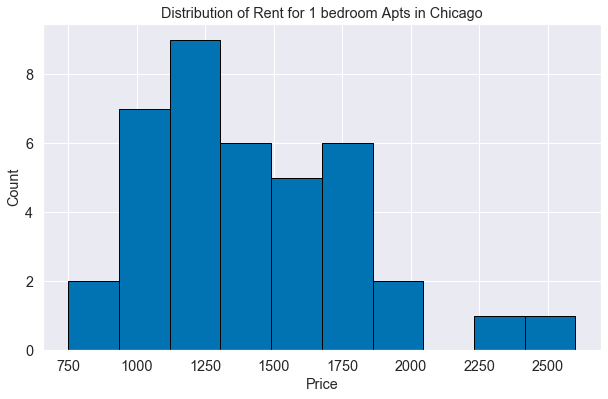

In [37]:
#start to look at the distributions
from matplotlib import figure
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.hist(one['Price'], edgecolor='black');
plt.xlabel("Price")
plt.ylabel('Count')
plt.title("Distribution of Rent for 1 bedroom Apts in Chicago");

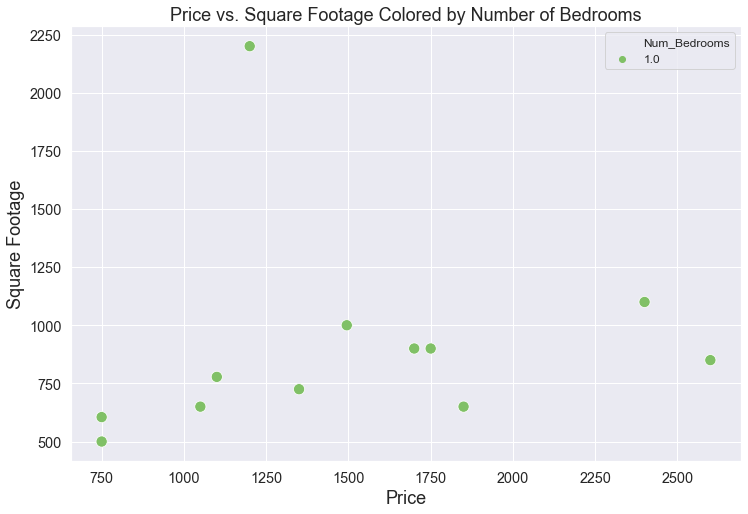

In [38]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.figure(figsize=(12, 8))
sns.scatterplot(x='Price', y='Sqft', hue='Num_Bedrooms', palette='summer', x_jitter=True, y_jitter=True, s=125, data=one.dropna())
plt.legend(fontsize=12)
plt.xlabel("Price", fontsize=18)
plt.ylabel("Square Footage", fontsize=18);
plt.title("Price vs. Square Footage Colored by Number of Bedrooms", fontsize=18);

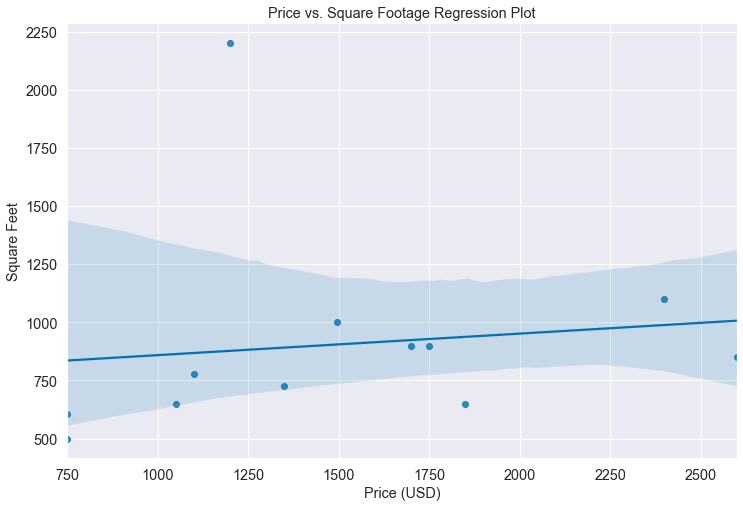

In [39]:
plt.figure(figsize=(12, 8))
sns.regplot(x='Price', y='Sqft', data=one.dropna());
plt.title('Price vs. Square Footage Regression Plot');
plt.xlabel("Price (USD)");
plt.ylabel("Square Feet");

In [40]:
#group by neighborhood
ch_apts.groupby('Neighborhood').mean()

,Num_Bedrooms,Sqft,Price
Neighborhood,,,
6948 S. Talman - Chicago Lawn,1.500000,600.00,800.000000
75Th & Dan Ryan,3.000000,NaN,850.000000
Andersonville,NaN,NaN,800.000000
Auburn Gresham,1.000000,605.00,750.000000
Brickyard,2.000000,900.00,1295.000000
Bucktown,2.000000,925.00,1362.500000
Buena Park,NaN,NaN,850.000000
Chicago,2.200000,893.40,1360.000000
Chicago Bridgeport,3.000000,NaN,1900.000000


In [41]:
#sort price to find cheapest
one.groupby('Neighborhood').mean()['Price'].sort_values()

Neighborhood
6948 S. Talman - Chicago Lawn     750.0
Auburn Gresham                    750.0
Chicago Lakeview Area             998.0
Uptown                            999.0
Jefferson Park                   1050.0
Pilsen                           1100.0
Lincoln Square                   1100.0
Edgewater                        1133.0
Wicker Park                      1195.0
Gold Coast - 1330 N. Dearborn    1260.0
Loop                             1300.0
Fulton                           1350.0
Humboldt Park                    1350.0
South Loop                       1497.5
River North - 100 W. Chestnut    1525.0
Gold Coast                       1543.0
Lakeview                         1564.5
River North                      1642.5
Old Town                         1685.0
Streeterville                    1745.0
Logan Square                     1750.0
West Loop                        1800.0
Chicago                          1850.0
Lincoln Park                     1900.0
Name: Price, dtype: float64

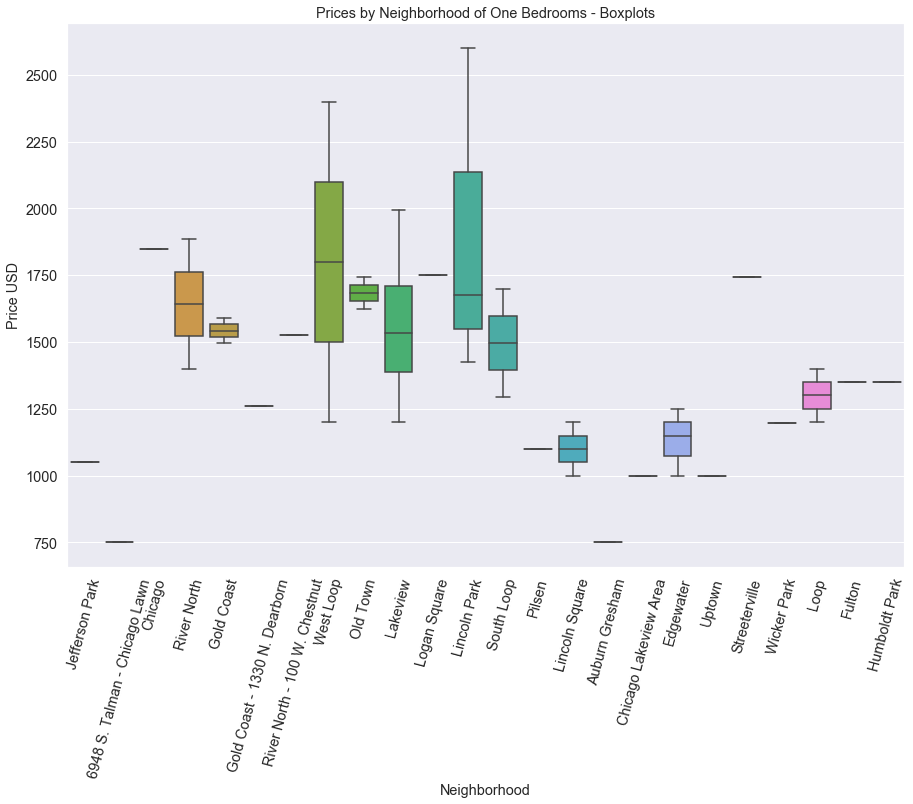

In [42]:
plt.figure(figsize=(15,10))
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

sns.boxplot(x='Neighborhood', y='Price', data=one)
plt.xlabel("Neighborhood");
plt.xticks(rotation=75)
plt.ylabel("Price USD");
plt.title("Prices by Neighborhood of One Bedrooms - Boxplots");